In [1]:
import cv2
import numpy as np
import sys
import matplotlib.pyplot as plt

In [2]:
def my_show(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [3]:
img1 = cv2.imread('test1.jpeg')
img2 = cv2.imread('test2.jpeg')

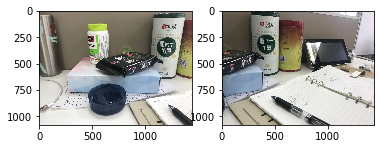

In [4]:
plt.subplot(121)
my_show(img1)
plt.subplot(122)
my_show(img2)

In [5]:
# 参数
radio = 0.85
min_match = 10
sift = cv2.xfeatures2d.SIFT_create()
smoothing_windows_size = 100

In [6]:
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
print(len(kp1))
des1.shape

3500


(3500, 128)

In [7]:
# match
matcher = cv2.BFMatcher()
raw_matcher = matcher.knnMatch(des1, des2, k=2)

In [8]:
good_point = []

for m1, m2 in raw_matcher:
    if m1.distance < radio * m2.distance:
        good_point.append(m1)

In [9]:
img3 = cv2.drawMatches(img1,kp1,img2,kp2,good_point,None,flags=2)

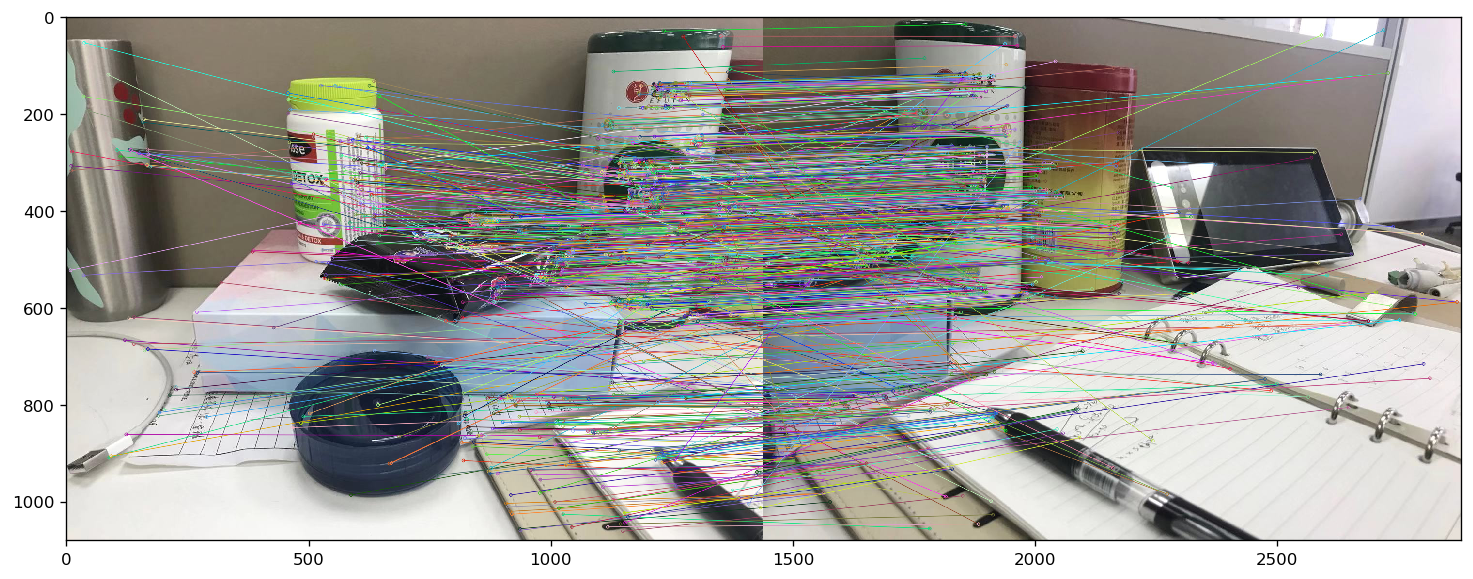

In [10]:
plt.figure(figsize=(15,8),dpi=120)
my_show(img3)

In [11]:
# homography from Ransac

if len(good_point) > min_match:
    image1_kp = np.float32([kp1[i.queryIdx].pt for i in good_point])
    image2_kp = np.float32([kp2[i.trainIdx].pt for i in good_point])
    
H, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC, 5.0)
H

array([[ 4.56390025e-01, -5.61913182e-02,  8.54456895e+02],
       [-1.37964449e-01,  8.91977325e-01,  6.99142355e+01],
       [-3.82157348e-04,  5.10373317e-05,  1.00000000e+00]])

In [12]:
# creat_mask
height_img1 = img1.shape[0]
width_img1 = img1.shape[1]
width_img2 = img2.shape[1]

height_panorama = height_img1
width_panorama = width_img1 + width_img2

offset = int(smoothing_windows_size / 2)
barrier = img1.shape[1] - int(smoothing_windows_size / 2)

mask1 = np.zeros((height_panorama, width_panorama))
mask2 = np.zeros((height_panorama, width_panorama))



mask1[:, barrier - offset: barrier + offset] = np.tile(np.linspace(1, 0, 2 * offset), (height_img1, 1))
mask1[:, : barrier - offset] = 1


mask2[:, barrier - offset: barrier + offset] = np.tile(np.linspace(0, 1, 2 * offset), (height_img1, 1))
mask2[:, barrier + offset :] = 1

mask1 = cv2.merge([mask1, mask1, mask1])
mask2 = cv2.merge([mask2, mask2, mask2])



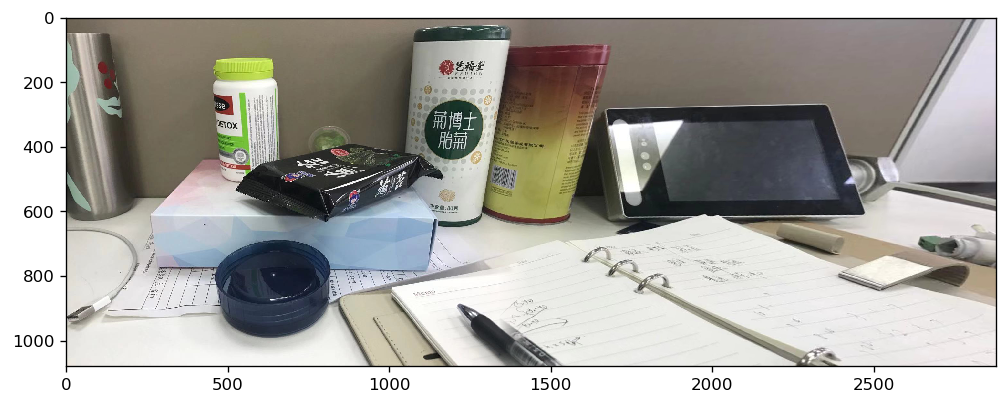

In [13]:
# blend

panorama1 = np.zeros((height_panorama, width_panorama, 3))
panorama1[0:img1.shape[0], 0:img1.shape[1],:] = img1
panorama1 *= mask1
# panorama1 = panorama1.astype(dtype='uint8')

panorama2 = cv2.warpPerspective(img2, H, (width_panorama, height_panorama)) * mask2
# panorama2 = panorama2.astype(dtype='uint8')

result = panorama1 + panorama2
result = result.astype('uint8')
plt.figure(figsize=(10,20),dpi=120)
my_show(result)


In [14]:
rows, cols = np.where(result[:,:,0] != 0)
min_row, max_row = min(rows), max(rows) + 1
min_col, max_col = min(cols), max(cols) + 1
final_result = result[min_row: max_row, min_col: max_col, :]

# cv2.imwrite('my_pan',final_result)

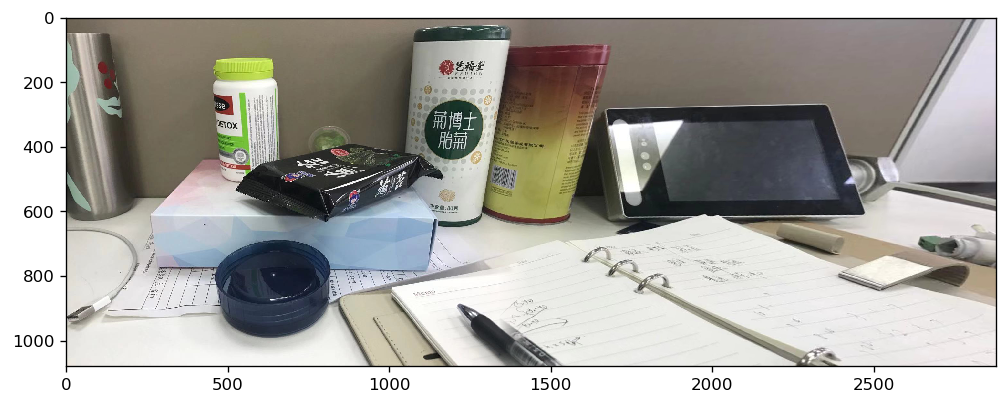

In [15]:
f = plt.figure(figsize=(10,7),dpi=120)
my_show(final_result)